# SEIR Generalize model with rho as a polynomial spline
#Author: Imelda Trejo 
#Created:February 17, 2022
#Last updated: Novemeber 11, 2022
#MCMC: coded by Yen-Ting Lin, LANL

In [1]:
# Import relevant modules
import numpy as np
import pandas as pd
import random
from scipy.stats import nbinom, expon
from scipy.special import factorial
from scipy.special import loggamma
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
from copy import copy
from matplotlib import cm
from scipy.integrate import simpson


In [2]:
#---------Polynomial spline
def Pspline(t,vk,c,k,q0):
    n = len(vk) - k
    assert (n >= k+1) and (len(c) >= n)
    return sum(c[i] * BaseSpline(t, k, i, vk,q0) for i in range(n))   
#---------mixing-monotonic-and-standar-Base
def BaseSpline(t,k,i,T,q0): #k0,,t0=6--->90
    n = len(t)
    b=np.zeros(n) ##base function of degree k-1
    if i<=q0:
        aux=BSpline.basis_element(T[i+1:i+k+1],extrapolate=False) #degree k-2
        a=aux.integrate(T[i+1],T[i+k+1])
        for j in range(0,tp):                                 #M-spline degree k-1
            b[j]=1-aux.integrate(T[1],t[j])/a
    else:
        b= BSpline.basis_element(vk[i:i+k+1],extrapolate=False)(t) #degree k-1
    return np.nan_to_num(b)

In [3]:
def computeDiffMtx(parLog, prefactor):
    
    length = len(parLog)
    
    meanParLog = np.zeros_like(parLog[:,:])

    for i in range(len(freeParameterInd)):

        par[freeParameterInd[i]] = parLog[-1,i]
        meanParLog[:,i] = parLog[:,i] - np.mean(parLog[:,i])

    diffMatrix = meanParLog.T.dot(meanParLog)/length

    diff = prefactor**2/parLog.shape[1]
    
    return diff, diffMatrix


In [4]:
#---Muk----ls days constant period----

def MuK(rho):
    mu = np.zeros(n+1)
    V = np.zeros(tp)
    hatI = np.zeros(m+1)
    V[0] = rho[0] * H[0, 0]

    for k in range(1, n+1):
        for i in range(0, m+1):
            hatI[i] = (h * (rho[m*(k-1)] * hatI[0] * psi[i] + 
                            2.0 * np.dot(rho[m*(k-1)+1 : m*(k-1)+i],
                                         np.flip(psi[1:i]))) )/ 2.0 + H[k-1, i]
        V[m*(k-1)+1 : k*m+1] = rho[m*(k-1)+1 : m*k+1] * hatI[1 : m+1]
        mu[k] = (h * (V[0] * W[k*m] + 2.0 * np.dot(V[1 : m*k], np.flip(W[1 : m*k])) + V[m*k] * W[0]) )/ 2.0
    
    return mu + 0.0001


# Ejemplo de uso:
# rho, H, psi, W, h, n, m, tp = ....  # tus datos aquí
# mu = MuK(rho, H, psi, W, h, n, m, tp)


In [5]:
#---Muk----ls days constant period----
#def MuK(rho): 
 #   mu,V,hatI=np.zeros(n+1),np.zeros(tp),np.zeros(m+1)
 #   V[0]=rho[0]*H[0,0]
 #   for k in range(1,n+1):
 #       for i in range(0,m+1):
 #           v=np.multiply(rho[m*(k-1):m*(k-1)+i],hatI[0:i])
 #           hatI[i]=h*(rho[m*(k-1)]*hatI[0]*psi[i]+2*np.dot(v[1:i],np.flip(psi[1:i])))/2+H[k-1,i] #hatI
 #       V[m*(k-1)+1:k*m+1]=np.multiply(rho[m*(k-1)+1:m*k+1],hatI[1:m+1]) #open-left
 #       mu[k]=h*(V[0]*W[k*m]+2*np.dot(V[1:m*k],np.flip(W[1:m*k]))+V[m*k]*W[0])/2    
 #   return mu+0.0001

In [6]:


#---log-likelihood, parameter in the variables rho_i>0
def LHFNeBinom(par):
    r,lam,L=np.exp(par[q]),np.exp(par[q+1]),0
    v=np.exp(Pspline(t,vk,par[0:q],4,q0)) #rho(t)
    muk=MuK(v)
    for k in range(1,n+1): #drop the first element
        aux2=loggamma(Y[k-1]+r)-(loggamma(r)+loggamma(Y[k-1]+1))
        L=L+Y[k-1]*np.log(muk[k]/(r+muk[k]))+r*np.log(r/(muk[k]+r))+aux2
    L=L-lam*np.dot(par[0:q],np.dot(Gr,par[0:q]))/2+q*np.log(lam)/2-q*(np.log(2*np.pi))/2   
    return L, v, muk


In [7]:
#Reproductive Number, trapezoidal rule approx, constant projection
def RepNumber(Q,psi):
    tp=len(psi)
    A,Rt=np.zeros((tp-1,tp-1)),np.zeros(tp)
    for k in range(0,tp-1): #drop the last element 
        A[k,0:tp-k-1]=Q[k+1:tp]   
        A[k,tp-k-1:]=Q[tp-1]*np.ones(k)    
    Rt[0:tp-1]=h*(2*np.dot(A,psi[1:tp])+psi[0]*Q[0])/2
    Rt[tp-1]=Rt[tp-2] 
    for k in range(0,tp-1):
        if Q[k]==0:
            #print(Rt[k])
            Rt[k]=0
    return Rt


In [8]:
def MCMC(iniPar, freeParameterInd, parameterBounds, diffMatrix, diff, maxIter, prefix,readysave):
    
    totalParN = len(freeParameterInd)      # number of parameters
    i=0
    print(readysave)
    if len(freeParameterInd)!= len(parameterBounds):
        
        print('The dimension of the bounds is not consistent with the free parameter list.')
        return

    parLog = np.zeros((maxIter,totalParN )) # An array that stores the parameters
    
    Rho = np.zeros((maxIter,tp))          # An array that stores the posterior
    
    Rt = np.zeros((maxIter,tp))          # An array that stores the posterior
    
    muk = np.zeros((maxIter,n+1))       # An array that stores the posterior



    acceptLog = np.zeros((maxIter,))               # An array that stores the acceptance

    logLLog = -1E30*np.ones((maxIter,))            # An array that stores the likelihood

    par = copy(iniPar)

    parLog[0,:] = par[freeParameterInd]

    oldLogL, oldRho, oldmuk = LHFNeBinom(par)

    logLLog[0] = oldLogL

    for index in range(1,maxIter):

        ifCut = True

        while ifCut:

            ifCut = False

            proposedPar = copy(par)

            proposedPar[freeParameterInd] = proposedPar[freeParameterInd] + diff*np.random.multivariate_normal(mean=np.zeros((totalParN,)), cov=diffMatrix)

            # shart prior cutoff here

            for kk in range(totalParN):

                ifCut = ifCut | (proposedPar[freeParameterInd[kk]] < parameterBounds[kk][0])
                ifCut = ifCut | (proposedPar[freeParameterInd[kk]] > parameterBounds[kk][1])


        newLogL, newRho, newmuk = LHFNeBinom(proposedPar)

        accept = False

        if newLogL > oldLogL:

            accept = True
            alpha = 1

        else:

            alpha = np.exp((newLogL-oldLogL))

            if np.random.random() < alpha :

                accept = True

        if accept:
            
            par = copy(proposedPar)
            
            oldLogL = copy(newLogL)
            
            acceptLog[index] = 1
            
            if readysave=='true':
                Rho[i,:]=newRho
                muk[i,:]=newmuk
                Rt[i,:]=RepNumber(newRho,psi)
                i=i+1

            
        logLLog[index] = oldLogL
        parLog[index,:] = par[freeParameterInd]

    
        if np.mod(index,100)==0:
            
            # display result every 100 iterations
            print('iteration='+str(index)+', logL='+str(logLLog[index])+', accept='+str(np.mean(acceptLog[:index])))
            
        
        if np.mod(index,1000)==0:

            # save results every 1000 iterations
            if readysave=='true':
                #np.savetxt(prefix+'logLLog.txt', logLLog)
                np.savetxt(prefix+'-parLog.txt', parLog)
                #np.savetxt(prefix+'acceptLog.txt', acceptLog)
                #np.savetxt(prefix+'RhoPosterior.txt',Rho)  #reprodutive rate
                #np.savetxt(prefix+'RtPosterior.txt',Rt)    #reproduction number
                #np.savetxt(prefix+'MukPosterior.txt',muk)
                #np.savetxt(prefix+'diffMatrix.txt', diffMatrix)
                #np.savetxt(prefix+'diff.txt', [diff,])
                #np.savetxt(prefix+'cont.txt',[i-1,])

    return logLLog, parLog, acceptLog

In [9]:
#0,1,...,6,...,9
key=0
state_names=['PUEBLA','MICHOACAN','MEXICO', "AGUASCALIENTES","TABASCO","BAJA_CALIFORNIA_SUR", "QUINTANA_ROO"]
state=state_names[key]
print(state)
##------------------------Read data------------

Y=np.load("%s.npy"%state)  #Incidence data


#---re-define data

#-----------------------Define the partition for the epidecmis time observed [0, T]  
n=np.size(Y)
print('observation days',n)

T,h,m=n,0.1,10
tp=int(T/h)+1            #total points
t=np.zeros(tp)
for i in range(0,tp):
    t[i]=h*i  




#--------------------Infectious period functions------#1-----------
Faux=np.load("F.npy")
Gaux=np.load("Gaux.npy") #1-G(t)
Psi=np.load("Psi.npy")
Aaux=np.load("A.npy")
Waux=np.load("W.npy")

#--------------------Infectious period functions------#2-----------
#Faux=np.load("F2.npy")
#Gaux=np.load("Gaux2.npy") #1-G(t)
#Psi=np.load("Psi2.npy")
#Aaux=np.load("A2.npy")    #1-G
#Waux=np.load("W2.npy")    #F-F

#--------------------Infectious period functions------#3-----------
#Faux=np.load("F2.npy")
#Gaux=np.load("Gaux.npy") #1-G(t)
#Psi=np.load("Psi3.npy")
#Aaux=np.load("A.npy")    #1-G
#Waux=np.load("W2.npy")    #F-F


#--------------------------Infectious period functions-----For--YenTingModel----------
#Faux=np.load("F_Lin.npy")
#Gaux=np.load("Gaux_Lin.npy")  #1-G(t)
#Psi=np.load("Psi_Lin.npy")
#Aaux=np.load("A_Lin.npy")
#Waux=np.load("W_Lin.npy")

#-----------------------redefine     
F=Faux[0:tp]
G=Gaux[0:tp]
psi=Psi[0:tp]  
A=Aaux[0:n,:]
W=Waux[0:tp]


PUEBLA
observation days 1021


In [10]:

#---History-function---H----
H=np.zeros((n,m+1))
for k in range(1,n):
    for i in range(0,m+1):
            H[k,i]=np.dot(Y[0:k],np.flip(A[0:k,i])) + Y[0]*Gaux[k*i] #adding I0  

In [11]:
#------------------------Base-spline interpolation----with partition (0,T)={0,xhi_1,...,xhi_q,T}
ls=21                    #length between the k-nots 
q=int(n/ls)+1            #total of nodes
vk=np.zeros(q)
for i in range(1,q-1):
    vk[i]=ls*i
vk[q-1]=n
#-------------------------------boundary-knots
vk=np.append([-3*ls,-2*ls,-ls],vk)
vk=np.append(vk,[n+ls,n+2*ls,n+3*ls])
#--------------Wigths
q=q+2  #base elements
print('Dimention of the Base-spline',q)    
#-------------------Bsplines functions: derivatives and gram matrix
q0=8                  #number of monotonic base functions
bd=np.zeros((q,tp-2)) ##array seconde derivatives of base function
Gr=np.zeros((q,q))    #Gram Matrix
print('monotonic properties till day:',vk[q0])
for i in range(0,q):
    bd[i,0:tp-2]=np.diff(BaseSpline(t,4,i,vk,q0),n=2)/(h*h)
for k in range(0,q):
    for j in range(0,q):
         #Gr[k,j]=np.trapz(np.multiply(bd[k],bd[j]),t[0:tp-2])            
        Gr[k,j]=simpson(np.multiply(bd[k],bd[j]),dx=t[1]-t[0])            

Dimention of the Base-spline 51
monotonic properties till day: 105.0


In [12]:
parameterBounds = np.zeros([q+2, 2])
parameterBounds[:,0] = -np.inf
parameterBounds[:,1] = np.inf
parameterBounds[:q0,0] = 0
freeParameterInd = range(0,q+2)

In [13]:
iniPar =np.random.rand(q+2)
iniDiffDiag = np.zeros(q+2)
diffMtx = np.diag(np.ones(q+2))
diff = 0.01 #005
maxIter=23001  
prefix=state
readysave='true'

In [14]:
#logLLog, parLog, acceptLog = MCMC(iniPar, freeParameterInd, parameterBounds, diffMtx, diff, maxIter, prefix,readysave)

The sampler seemed to have found a suitable region; the following segment is used to compute the covariance matrix

In [15]:
#plt.plot(logLLog[logLLog>-1e15])

In [16]:
#maxLindex = np.where(logLLog==np.amax(logLLog))[0][0]
#par = parLog[maxLindex,:]
#diff, diffMtx = computeDiffMtx(parLog[logLLog>-1e15,:][20:], 2.5)  # 2.38 for Gaussian is too low (accept~0.58)
#plt.imshow(diffMtx, cmap=cm.plasma)
#plt.colorbar()

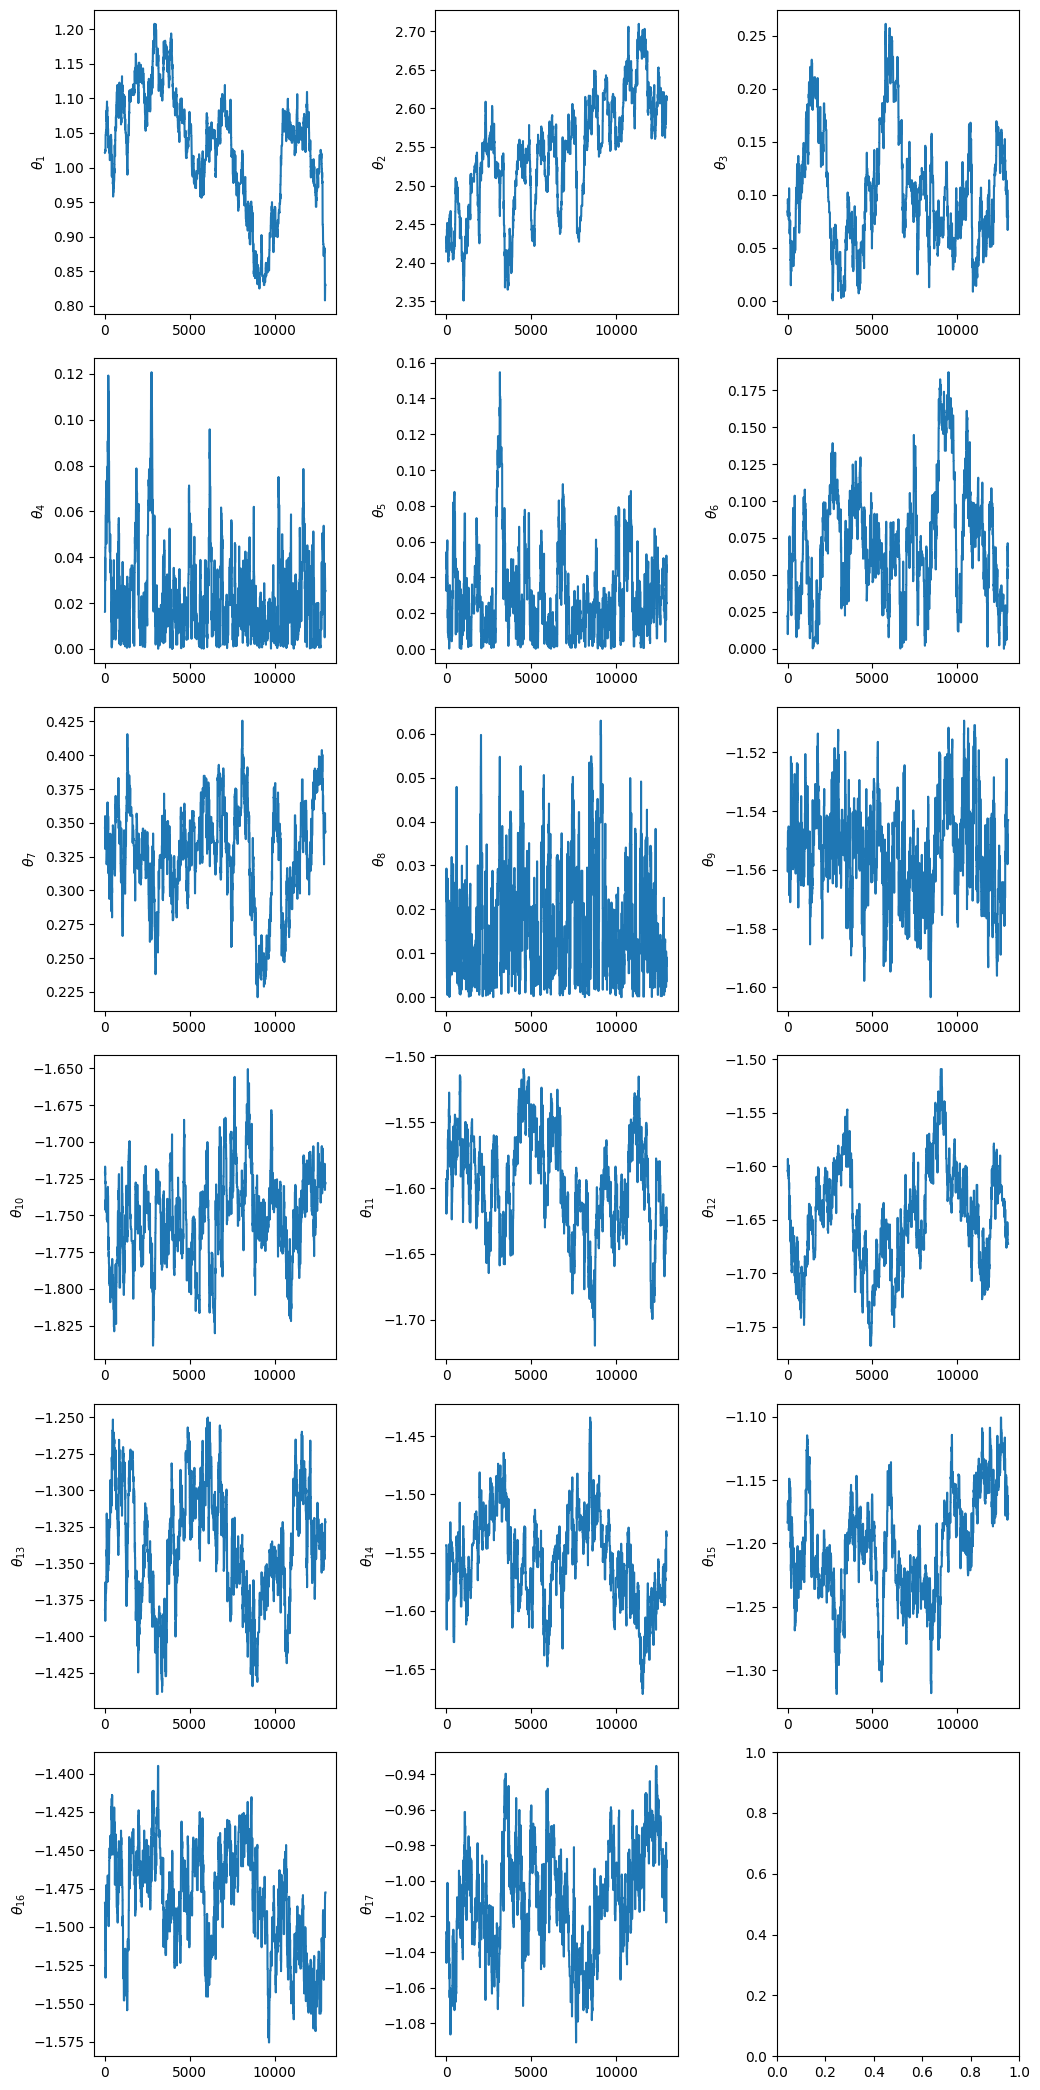

In [17]:
prefix=state
parLog = np.genfromtxt(prefix+'-parLog.txt')

fig, ax = plt.subplots(6,3,figsize=(10.5, 21))
onset = 10000
offset = len(parLog)

for i in range(6):    
     for j in range(3):
    
         if (3*i+j)<17:
            ax[i,j].plot(parLog[onset:offset,3*i+j])
            ax[i,j].set_ylabel('$\\theta_{'+str(1+3*i+j)+'}$')
        
fig.tight_layout()

0.031886792452830194


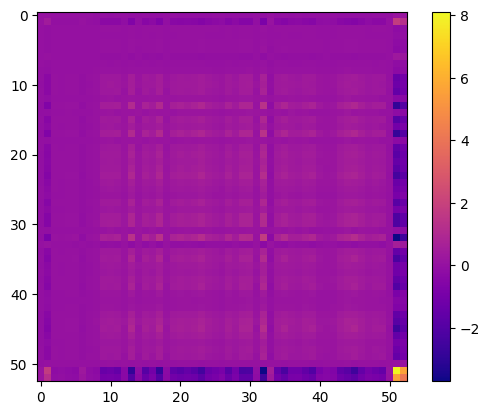

In [18]:
par=parLog[-1,:]

diff, diffMtx = computeDiffMtx(parLog, 1.3)  # 2.38 for Gaussian is too low (accept~0.58)
print(diff)
plt.imshow(diffMtx, cmap=cm.plasma)
plt.colorbar()

In [19]:
readysave='true'
prefix='round-2-'+state
maxIter=20001   # Very long because I ran it overnight. I stopped it around 250K iteration (~8 hours)
logLLog, parLog, acceptLog = MCMC(par, freeParameterInd, parameterBounds, diffMtx, diff, maxIter, prefix,readysave)

true
iteration=100, logL=-3558.965878511147, accept=0.12
iteration=200, logL=-3554.8945299489233, accept=0.11
iteration=300, logL=-3553.6141502112023, accept=0.09666666666666666
iteration=400, logL=-3552.6778289866547, accept=0.1
iteration=500, logL=-3555.2719962095557, accept=0.1
iteration=600, logL=-3554.6607968713565, accept=0.09666666666666666
iteration=700, logL=-3559.557117733057, accept=0.09571428571428571
iteration=800, logL=-3554.826248078327, accept=0.09625
iteration=900, logL=-3555.3045917142404, accept=0.09888888888888889
iteration=1000, logL=-3551.9016429042654, accept=0.097
iteration=1100, logL=-3555.078588041886, accept=0.09909090909090909
iteration=1200, logL=-3557.7040779536974, accept=0.09833333333333333
iteration=1300, logL=-3555.879693739682, accept=0.10461538461538461
iteration=1400, logL=-3555.1734399193883, accept=0.10214285714285715
iteration=1500, logL=-3555.2208828869384, accept=0.102
iteration=1600, logL=-3552.4713951851422, accept=0.100625
iteration=1700, lo

In [24]:
maxLindex = np.where(logLLog==np.amax(logLLog))[0][0]
par = parLog[maxLindex,:]
diff, diffMtx = computeDiffMtx(parLog[logLLog>-1e15,:][0:], 1.5)  # 2.38 for Gaussian is too low (accept~0.58)
print(diff)
# plt.imshow(diffMtx, cmap=cm.plasma)
# plt.colorbar()

readysave='true'
prefix='round-3-'+state
maxIter=301   # Very long because I ran it overnight. I stopped it around 250K iteration (~8 hours)
logLLog, parLog, acceptLog = MCMC(par, freeParameterInd, parameterBounds, diffMtx, diff, maxIter, prefix,readysave)

0.04245283018867924
true
iteration=100, logL=-3548.361475846077, accept=0.88
iteration=200, logL=-3551.5774999277687, accept=0.895
iteration=300, logL=-3549.5669578314437, accept=0.89


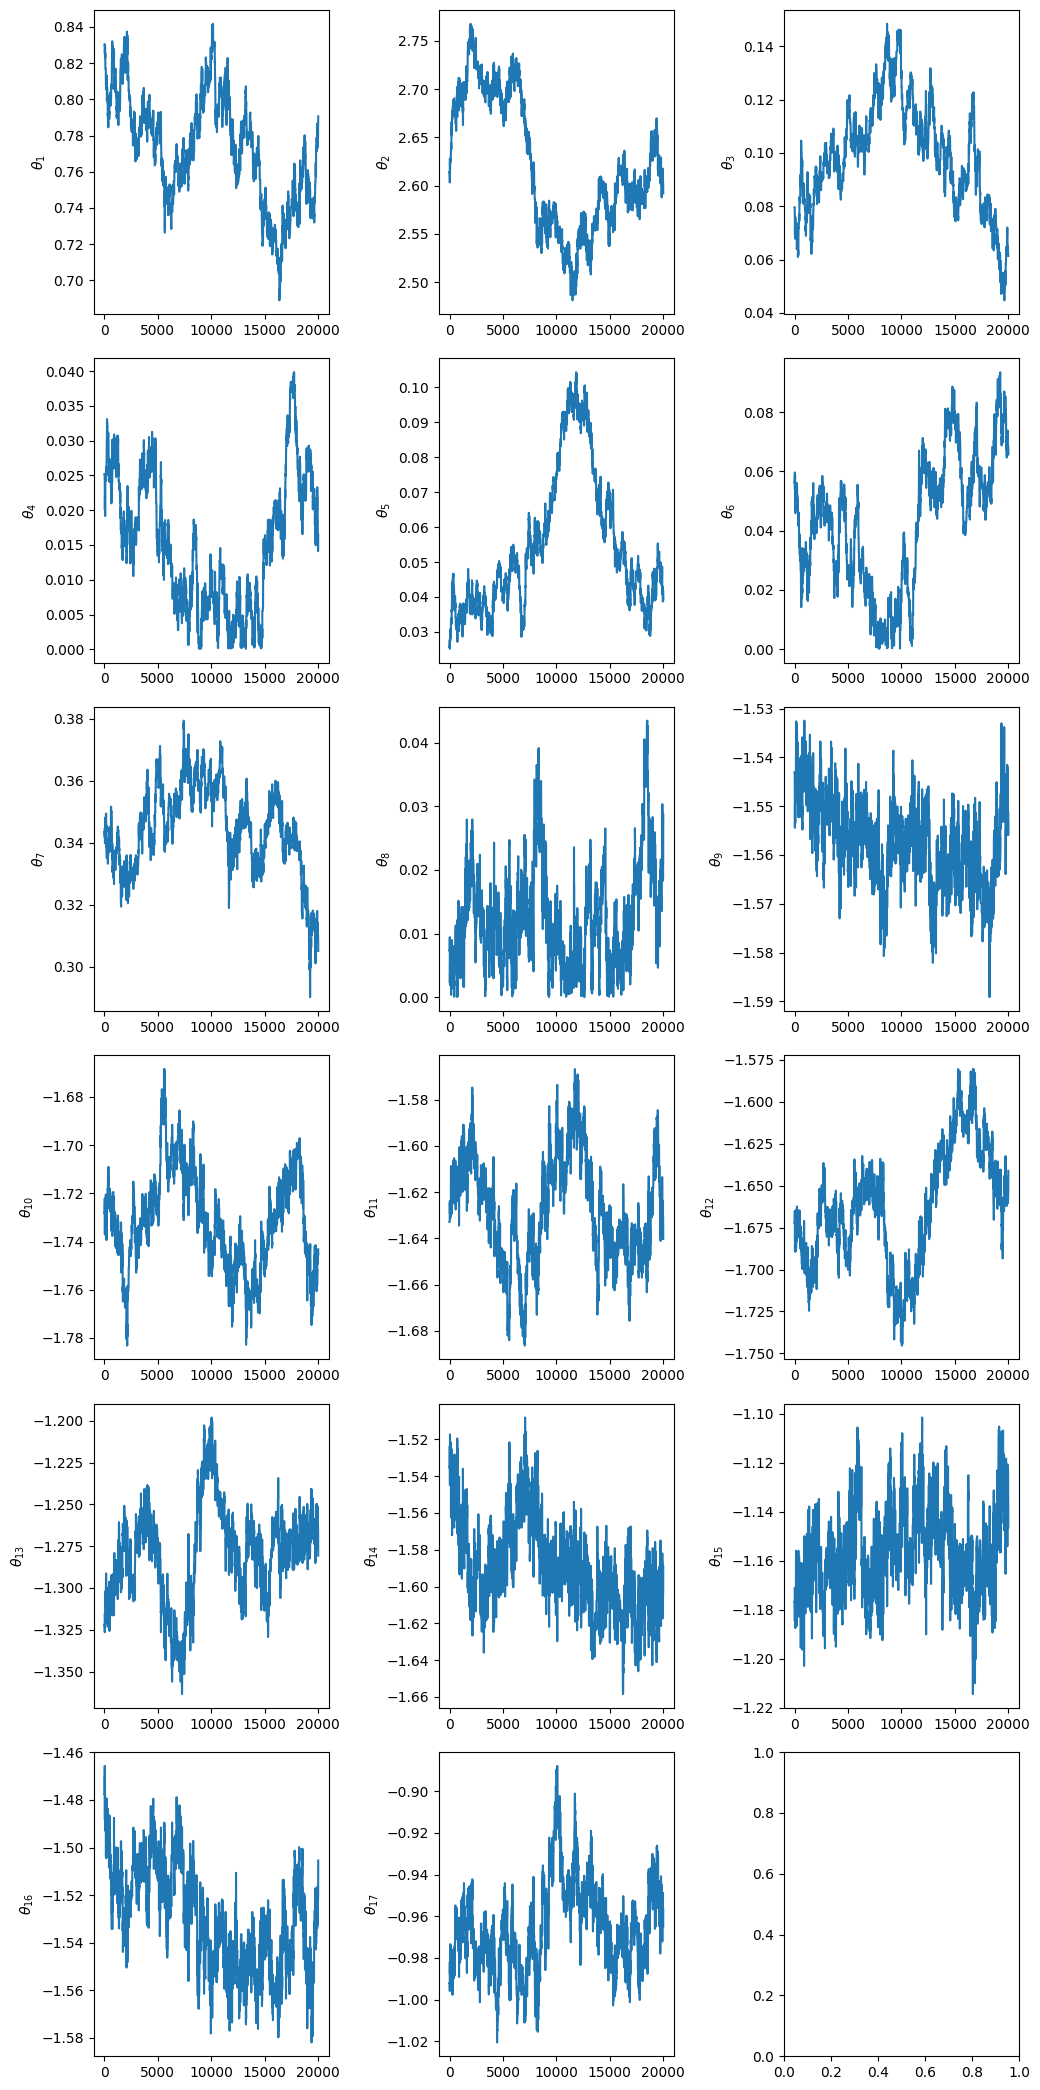

In [21]:
parLog = np.genfromtxt(prefix+'-parLog.txt')

fig, ax = plt.subplots(6,3,figsize=(10.5, 21))

for i in range(6):    
     for j in range(3):
    
         if (3*i+j)<17:
            ax[i,j].plot(parLog[0:maxIter,3*i+j])
            ax[i,j].set_ylabel('$\\theta_{'+str(1+3*i+j)+'}$')
        
fig.tight_layout()